# 最优市场组合

In [36]:
# 导入包
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import qstock as qs

In [37]:
# 五因子模型选出来的股票
stock_data = pd.read_excel('五因子模型参数结果.xlsx', nrows=20) # 只要前面20行数据
stock_code = list(map(lambda x : x.split('.')[0],stock_data['company']))

# 沪深300中文名字
df_chinese_name = qs.index_member('hs300')

# 利用qstock获取股票数据
start_time = '20200701'
end_time = '20230630'

def get_data(stock_code,start_time,end_time):
    
    # 获取成分股列表
    data = qs.get_data(code_list=stock_code, start=start_time, end=end_time, freq='d', fqt=2)
    data = data.reset_index()
    
    # 处理数据格式
    data = data.loc[:,['date','name','close']].copy()
    data = data.pivot_table(index='date',columns='name', values='close')
    
    return data

data = get_data(stock_code,start_time,end_time)

# 计算所有股票的对数收益率
stock_ret = data.apply(lambda x : np.log(x / x.shift(1)))

100%|████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 1430.36it/s]


# 进行10000次蒙特卡洛实验，股票组合可行集

In [38]:
# 1.进行10000次蒙特卡洛实验，计算10000次实验的股票组合年化收益率及方差

selected_stocks = stock_ret.columns.tolist()

# 计算每个股票组合年化收益率及方差
def get_ret_cov(selected_stocks,stock_ret):
    
    # 随机生成股票组合中各股票的权重[数组中的元素是在 0 到 1 之间均匀分布的随机数]
    weights = np.random.random(len(selected_stocks))
    weights /= np.sum(weights)  # 股票权重归一化处理,确保所有股票权重之和为1

    # 计算组合年化收益率
    port_ret = np.sum(stock_ret.mean() * weights) * 252
    
    # 计算组合年化方差
    port_vol = np.sqrt(np.dot(weights.T, np.dot(stock_ret.cov() * 252, weights)))
    
    # 计算夏普比率
    sharpe_ratio = port_ret/port_vol
    
    # 组合年化收益率及方差数据
    res = pd.DataFrame(dict({'port_ret':round(port_ret,4),
                             'port_vol':round(port_vol,4),
                             'sharpe_ratio':round(sharpe_ratio,4)}),index=[0])

    return res

# 1. 10000次蒙特卡洛实验的结果
res_10000 = pd.DataFrame()
for i in range(10000):
    res = get_ret_cov(selected_stocks,stock_ret)
    res_10000 = pd.concat([res_10000,res],ignore_index=True)
    
res_10000

,port_ret,port_vol,sharpe_ratio
0,0.2277,0.2440,0.9330
1,0.1826,0.2561,0.7132
2,0.2118,0.2345,0.9030
3,0.2606,0.2526,1.0315
4,0.2189,0.2646,0.8273
...,...,...,...
9995,0.1546,0.2344,0.6595
9996,0.2680,0.2376,1.1276
9997,0.2465,0.2733,0.9019
9998,0.1967,0.2265,0.8684


Text(0, 0.5, 'prot_ret')

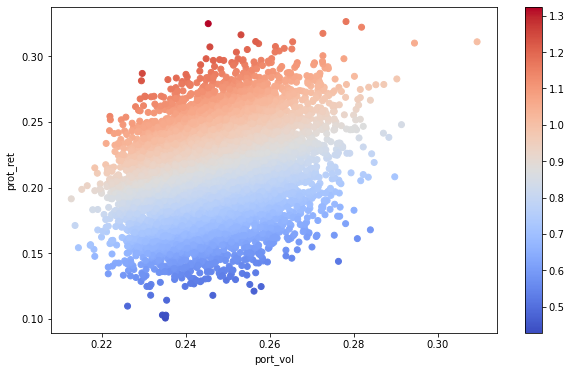

In [39]:
# 2.10000次蒙特卡洛实验得到的投资组合可行集画图

# 设置画布大小
plt.figure(figsize=(10,6))
plt.scatter(res_10000['port_vol'],
            res_10000['port_ret'],
            c = res_10000['sharpe_ratio'],
            cmap = 'coolwarm',
            marker='o')

plt.colorbar()
plt.xlabel('port_vol')
plt.ylabel('prot_ret')

# 画出有效前沿

In [40]:
# 1.利用优化函数查找有效前沿上的点，最小方差组合&最大夏普比率组合
import scipy.optimize as sco

# 无风险利率
rf = float(0.018)

# 计算组合年化收益率
def get_port_ret(weights):
    port_ret = np.sum(stock_ret.mean() * weights) * 252
    return port_ret

# 计算组合年化方差
def get_port_vol(weights):
    port_vol = np.sqrt(np.dot(weights.T, np.dot(stock_ret.cov() * 252, weights)))
    return port_vol

# 等权重比例
eweights = np.array(len(selected_stocks) * [1. / len(selected_stocks),])

# 组合权重约束条件,类型eq等式，函数等于0
cons = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1}) 

# 限制weight的取值在0-1之间
bnds = tuple((0, 1) for x in range(len(eweights)))  

# 1.求最大夏普比率，即求最小化夏普比率的负数
# 目标优化函数
def min_func_sharpe(weights): 
    return -(get_port_ret(weights)-rf) / get_port_vol(weights)

# 最大化夏普比率组合的权重
max_func_sharpe_res = sco.minimize(min_func_sharpe, eweights, method='SLSQP', bounds=bnds, constraints=cons)
max_func_sharpe_weight = max_func_sharpe_res['x']

# 2.求最小方差组合的权重
min_port_vol = sco.minimize(get_port_vol, eweights, method='SLSQP', bounds=bnds, constraints=cons)
min_port_vol_weight = min_port_vol['x']


In [41]:
# 2.给定组合收益率,挑选组合方差最小的投资组合【挑选有效边界上的投资组合】

# 2个约束条件，第一个约束条件：预期组合收益率与目标组合收益率的差值为0；第二个约束条件：确保所有资产组合权重和为1
cons_new = ({'type': 'eq', 'fun': lambda x: get_port_ret(x) - tret}, 
            {'type': 'eq', 'fun': lambda x: np.sum(x) - 1})

# 目标组合收益率,即在一定收益率下,选择最小方差的一定收益率
trets = np.linspace(0.1,0.6,100)   # 在蒙特卡洛图显示组合的收益率在0.1-0.6之间，生成100个数组

min_port_vols = [] # 最小方差的点
for tret in trets: 
    res = sco.minimize(get_port_vol, eweights, method='SLSQP', bounds=bnds, constraints=cons_new) 
    min_port_vols.append(res['fun'])

min_port_vols

[0.1905409604570827,
 0.19015927275583686,
 0.18981571980755174,
 0.18950983880060746,
 0.18924309831268105,
 0.18901563508284502,
 0.1888262531063245,
 0.18867580625255548,
 0.18856439623604956,
 0.18849210511389597,
 0.18845585888930236,
 0.18844844796160307,
 0.18847258704781147,
 0.1885272959430794,
 0.18862252990878495,
 0.18876207306796733,
 0.18894591980417946,
 0.18917363679968474,
 0.18944476714795555,
 0.1897590034378338,
 0.19011540926908926,
 0.1905136146873445,
 0.19095333568945994,
 0.19143388982112639,
 0.19195487813834652,
 0.19251666810505413,
 0.1931192688496188,
 0.19376216593240034,
 0.1944456800254478,
 0.19517272860047832,
 0.19594326406188814,
 0.19675678806458063,
 0.1976127725777683,
 0.19851066867292402,
 0.19944991029423423,
 0.20042991553880835,
 0.20145009034245612,
 0.2025098279624847,
 0.2036085093372629,
 0.20474551144168593,
 0.20592020598966762,
 0.20713195743114768,
 0.20838013657759472,
 0.20966434470671388,
 0.21098405206615922,
 0.21233881550201447

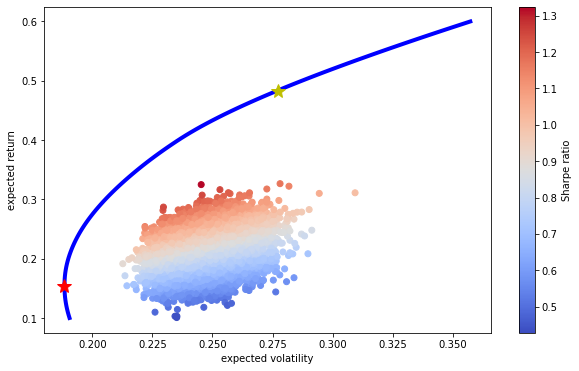

In [42]:
# 画有效前沿边界

plt.figure(figsize=(10, 6))

# 蒙特卡洛实验的数据
plt.scatter(res_10000['port_vol'],
            res_10000['port_ret'],
            c = res_10000['sharpe_ratio'],
            cmap = 'coolwarm',
            marker='o')

# 有效边界
plt.plot(np.array(min_port_vols),trets, 'b', lw = 4.0)

# 夏普比率最大的值与方差最小的组合的点
plt.plot(get_port_vol(max_func_sharpe_weight),get_port_ret(max_func_sharpe_weight), 'y*', markersize=15.0) 
plt.plot(get_port_vol(min_port_vol_weight), get_port_ret(min_port_vol_weight),'r*', markersize=15.0) 

plt.xlabel('expected volatility') 
plt.ylabel('expected return') 
plt.colorbar(label='Sharpe ratio')

# 有效前沿不靠近圆点的原因，有些股票权重为0

# 画资本市场线

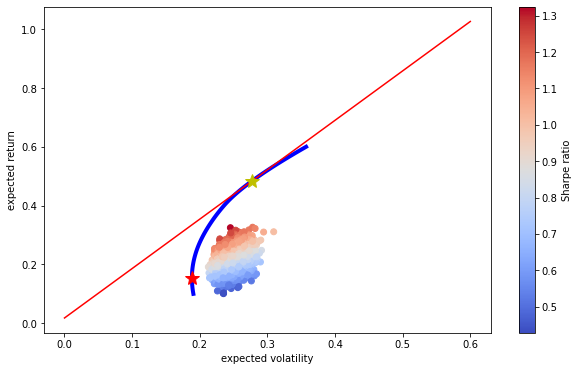

In [43]:
# 引入无风险资产的点与夏普比率最大的点的连线，即为CML与有效前沿的切线

plt.figure(figsize=(10, 6))

# 蒙特卡洛实验的数据
plt.scatter(res_10000['port_vol'],
            res_10000['port_ret'],
            c = res_10000['sharpe_ratio'],
            cmap = 'coolwarm',
            marker='o')

# 有效边界
plt.plot(np.array(min_port_vols),trets, 'b', lw = 4.0)

# 资本市场线[两点确定一条直线]
plt.plot((0,0.6),(rf,rf+(get_port_ret(max_func_sharpe_weight)-rf)/get_port_vol(max_func_sharpe_weight)*0.6), 'r', lw=1.5)

# 夏普比率最大的值与方差最小的组合的点
plt.plot(get_port_vol(max_func_sharpe_weight),get_port_ret(max_func_sharpe_weight), 'y*', markersize=15.0) 
plt.plot(get_port_vol(min_port_vol_weight), get_port_ret(min_port_vol_weight),'r*', markersize=15.0) 

plt.xlabel('expected volatility') 
plt.ylabel('expected return') 
plt.colorbar(label='Sharpe ratio')



In [46]:
# 最优风险组合的权重即为夏普比率最高的组合权重。
# 而个人效用函数与CML直线的切点是无风险资产与风险资产的配置比例点

res_df = pd.DataFrame({'股票代码':stock_code,'权重':max_func_sharpe_weight.round(3)})
res_df = pd.merge(left=res_df,right=df_chinese_name[['股票代码','股票名称']],on='股票代码',how='left')
res_df

,股票代码,权重,股票名称
0,002920,0.000,德赛西威
1,601689,0.069,拓普集团
2,600732,0.000,爱旭股份
3,300308,0.000,中际旭创
4,000568,0.000,泸州老窖
5,000596,0.210,古井贡酒
6,300498,0.000,温氏股份
7,300014,0.048,亿纬锂能
8,603369,0.000,今世缘
9,605117,0.165,德业股份
